In [1]:
import numpy as np
import json
import pandas as pd
from pathlib import Path
from skimage import measure
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

In [2]:
root_path = Path('data')
img_path = Path('/home/iref/PycharmProjects/CSA_new_pipeline/core-sample-snakemake/data/raw/photos/')

In [3]:
test = np.load(root_path / 'raw/matrixes/matrix_1000072__69adcb70_0c67_46c3_9117_923fd94c00c8.npz')['data']
test_img = Image.open(img_path / 'Field0_Well0/1000072.jpeg')

In [4]:
print(np.unique(test))
print(test.shape)
np.asarray(test_img).shape

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
(4134, 381)


(4134, 381, 3)

In [27]:
def prepare_data(labels_path=root_path / 'raw/matrixes', 
                 images_path = img_path, 
                 data_path = root_path / 'raw/segmented_data.csv',
                 experts_only = True):
    data = pd.read_csv(data_path)
    white_list = ['Песчаник', 'Алевролит', 'Аргиллит', 'Переслаивание пород']
    data = data[data['segment_value'].isin(white_list) & (data['photo_type'] == 'ДС') 
                & (data['segment_type'] == 'Порода')]
    data = data[['photo_id','task_id','user','segment_num','segment_value']]
    if experts_only:
        users_list = ['markup_expert01', 'markup_expert02']
        data = data[data['user'].isin(users_list)]
    photo_ids = list(set(data['photo_id']))
    return data

In [28]:
main_df = prepare_data()
main_df.to_csv(root_path / 'cleared.csv', index=False)
main_df = pd.read_csv(root_path / 'cleared.csv')
main_df
# print(main_df['photo_id'].value_counts())
# main_df_clear = main_df[main_df['segment_value']!='Переслаивание пород']
# main_df_clear['photo_id'].value_counts()

,photo_id,task_id,user,segment_num,segment_value
0,1008462,107a6c34_19e2_4bd6_a4b7_7f0251bb2ea0,markup_expert01,0,Переслаивание пород
1,1008462,107a6c34_19e2_4bd6_a4b7_7f0251bb2ea0,markup_expert01,1,Песчаник
2,1003336,10f0518a_5f16_408d_9fb7_7750a98f3a0c,markup_expert01,0,Песчаник
3,1002244,20c900c8_a082_4a92_99c4_2da482f6b8c7,markup_expert01,0,Переслаивание пород
4,1011830,217b97ba_da61_4eb9_a45c_2f7f0932f22b,markup_expert01,1,Песчаник
...,...,...,...,...,...
2140,1000072,69adcb70_0c67_46c3_9117_923fd94c00c8,markup_expert02,10,Алевролит
2141,1000072,69adcb70_0c67_46c3_9117_923fd94c00c8,markup_expert02,11,Песчаник
2142,1000072,69adcb70_0c67_46c3_9117_923fd94c00c8,markup_expert02,12,Песчаник
2143,1010492,6aeb738a_37ec_431f_bef5_0b416a519ab2,markup_expert02,0,Песчаник


In [113]:
main_df[main_df['photo_id']==1000072]['segment_num'].values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [124]:
segments_to_labels = {
    'Аргиллит': 0,
    'Алевролит': 1,
    'Песчаник': 2,
    'Переслаивание пород': 3
}

photos = main_df['photo_id'].unique()
for p_id in photos:
    temp_df = main_df[main_df['photo_id']==p_id]
    task_id = temp_df['task_id'].values[0]
    file_name = f'matrix_{p_id}__{task_id}.npz'
    matrix = np.load(root_path/'raw/matrixes'/file_name)['data']
    
    for index, row in temp_df.iterrows():
        seg_num = row['segment_num']
        seg_val = row['segment_value']
        res = np.where(matrix == seg_num, segments_to_labels[seg_val], matrix)
        np.savez_compressed(root_path/'interim/converted_matrixes'/file_name, res)

In [126]:
photos.shape

(753,)

In [5]:
converted_test = np.load(root_path/'interim/converted_matrixes/matrix_1000072__69adcb70_0c67_46c3_9117_923fd94c00c8.npz')

In [6]:
test

array([[ 0,  0,  0, ...,  1,  1,  1],
       [ 0,  0,  0, ...,  1,  1,  1],
       [ 0,  0,  0, ...,  1,  1,  1],
       ...,
       [12, 12, 12, ..., 12, 12, 12],
       [12, 12, 12, ..., 12, 12, 12],
       [12, 12, 12, ..., 12, 12, 12]], dtype=uint8)

In [71]:
converted_test['arr_0'].transpose(2, 0, 1)

ValueError: axes don't match array

In [25]:
f_list = {}
for (dirpath, dirnames, filenames) in os.walk(img_path):
    for file in filenames:
        f_list[file[:-5]] = img_path / dirpath / file

In [ ]:
f_list

In [ ]:
for idd in main_df['photo_id'].values:
        print(f_list[str(idd)])

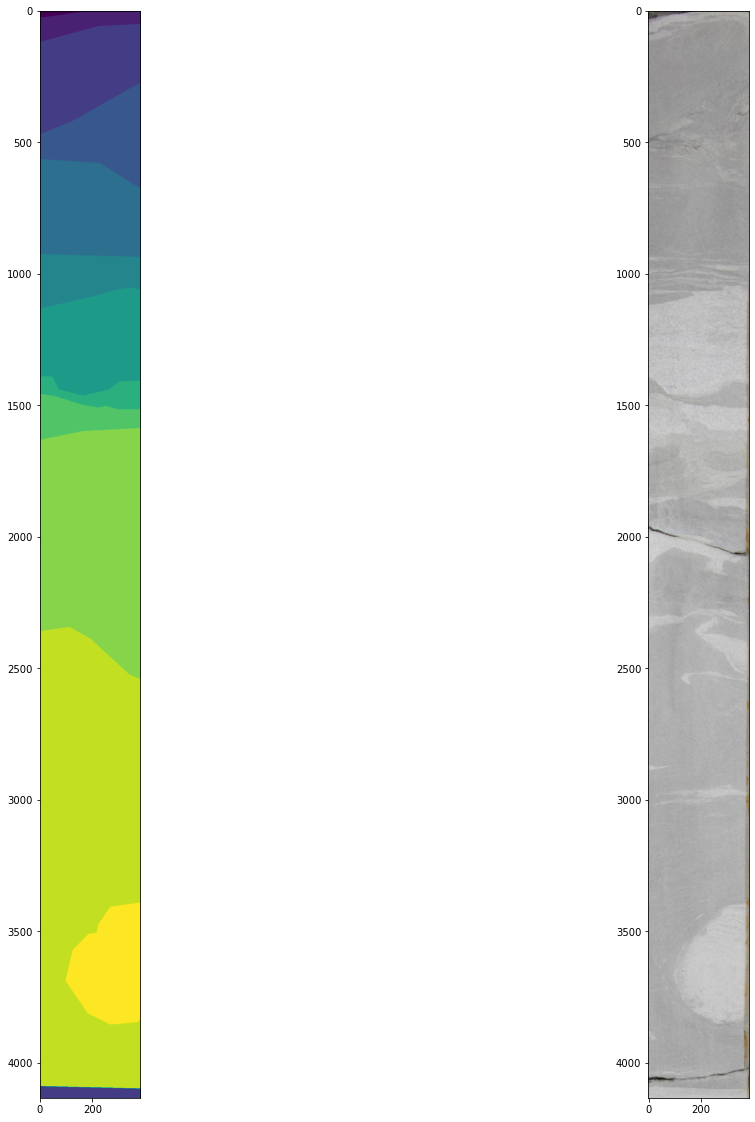

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))
ax1.imshow(converted_test['arr_0'])
ax2.imshow(test_img)

In [4]:
from data_extraction import SegDataset, ToTensor, Normalize, Resize

In [9]:
data_transforms = {
    'Train': transforms.Compose([Resize(imageresize=(512, 512), maskresize=(512, 512)),ToTensor(), Normalize()]),
    'Test': transforms.Compose([Resize(imageresize=(512, 512), maskresize=(512, 512)), ToTensor(), Normalize()]),
}

In [10]:
test_ds = SegDataset(root_path / 'Dataset', imageFolder='Images', maskFolder='Masks',seed=100, fraction=0.2, subset='Train', transform=data_transforms['Train'])

In [11]:
[(test_ds[5][x].shape, test_ds[5][x].shape) for x in ['image', 'mask']]

[(torch.Size([3, 512, 512]), torch.Size([3, 512, 512])),
 (torch.Size([1, 512, 512]), torch.Size([1, 512, 512]))]

In [12]:
test_dl = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=1)

In [15]:
it = iter(test_dl)
next(it)

{'image': tensor([[[[0.0941, 0.0784, 0.0745,  ..., 0.0745, 0.0784, 0.0824],
           [0.0941, 0.0863, 0.0784,  ..., 0.0784, 0.0784, 0.0863],
           [0.0902, 0.0902, 0.0784,  ..., 0.0863, 0.0784, 0.0784],
           ...,
           [0.2902, 0.2784, 0.2824,  ..., 0.0980, 0.0941, 0.1020],
           [0.2314, 0.2510, 0.2588,  ..., 0.0980, 0.0980, 0.1020],
           [0.1647, 0.1647, 0.1569,  ..., 0.1137, 0.1255, 0.1059]],
 
          [[0.0941, 0.0824, 0.0824,  ..., 0.0706, 0.0667, 0.0706],
           [0.0784, 0.0745, 0.0627,  ..., 0.0706, 0.0706, 0.0667],
           [0.0784, 0.0745, 0.0627,  ..., 0.0706, 0.0667, 0.0627],
           ...,
           [0.2471, 0.2353, 0.2392,  ..., 0.0824, 0.0784, 0.0941],
           [0.1882, 0.2078, 0.2157,  ..., 0.0863, 0.0863, 0.0941],
           [0.1255, 0.1216, 0.1098,  ..., 0.0941, 0.1059, 0.0941]],
 
          [[0.0941, 0.0824, 0.0863,  ..., 0.0745, 0.0745, 0.0902],
           [0.0784, 0.0784, 0.0784,  ..., 0.0745, 0.0745, 0.0784],
           [0.0